## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

## Get Data

In [2]:
dat = pd.read_pickle('./data/processed/final/all-sched-enriched.pkl')
dat.head()

,operator,flight,aircraft,craft_capacity,frequency,weekly_flights,weekly_capacity,weekly_est_pass,from,from_time,...,to_time_slot,eff_from,eff_to,day_1,day_2,day_3,day_4,day_5,day_6,day_7
0,IND,6E 101,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,MAA,6.25,...,15.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
1,IND,6E 103,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,PNQ,22.33,...,1.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
2,IND,6E 104,A 320,183,"[1, 2, 3, 4, 5, 6, 7]",7,1281,1125.0,HYD,8.17,...,23.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,True,True
3,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,PNQ,17.33,...,38.0,2019-10-27 00:00:00,2020-03-28 00:00:00,True,True,True,True,True,False,True
4,IND,6E 105,A 320,183,"[1, 2, 3, 4, 5, 7]",6,1098,964.0,DEL,14.75,...,34.0,2019-10-27 00:00:00,2020-03-27 00:00:00,True,True,True,True,True,False,True


### Overview

In [3]:
n_flights = dat['weekly_flights'].sum()
operators = dat['operator'].unique()
n_operators = len(operators)
cities = list(set(dat['from'].tolist() + dat['to'].tolist()))
n_cities = len(cities)

print('In a week, %i operators run %i domestic flights into and out of %i Indian cities.\n' % 
      (n_operators, n_flights, n_cities))
print('A flight departs from and arrives into a different city, so the %i flights result in' % n_flights)
print('a weekly total of %i arrivals and departures.' % (2*n_flights))

In a week, 9 operators run 21953 domestic flights into and out of 102 Indian cities.

A flight departs from and arrives into a different city, so the 21953 flights result in
a weekly total of 43906 arrivals and departures.


### Cities

<ul>
    <li>Create a new dataframe by wrangling the dataframe to identify for each city, across all carriers:
        <ol>
            <li>weekly total number of flights (arrivals plus departures).
            <li>weekly capacity.
            <li>weekly estimated passengers
        </ol>
</ul>

Identify the top cities that account for 80% of all weekly totals.

In [26]:
weeklies_ = ['weekly_flights', 'weekly_capacity', 'weekly_est_pass']

from_flights = dat.groupby(['from'])[weeklies_].sum()
to_flights = dat.groupby(['to'])[weeklies_].sum()

sdat = pd.concat([from_flights, to_flights], axis = 1, ignore_index = True)
sdat = sdat.fillna(0, axis = 1, downcast = 'infer') # if there are no flights either from or 
                                                                  # to a city, replace NA by 0
sdat = sdat.rename(columns = {0:'from_weekly_flights', 
                                            3:'to_weekly_flights',
                                            1:'from_weekly_capacity',
                                            4:'to_weekly_capacity',
                                            2:'from_weekly_est_pass',
                                            5:'to_weekly_est_pass'}, errors = 'raise')

sdat['total_weekly_flights'] = sdat.apply(lambda row: 
                                                        row.from_weekly_flights + row.to_weekly_flights,
                                                        axis = 1)
sdat['total_weekly_capacity'] = sdat.apply(lambda row: 
                                                        row.from_weekly_capacity + row.to_weekly_capacity,
                                                        axis = 1)
sdat['total_weekly_est_pass'] = sdat.apply(lambda row: 
                                                        row.from_weekly_est_pass + row.to_weekly_est_pass,
                                                        axis = 1)

sdat.head()

,from_weekly_flights,from_weekly_capacity,from_weekly_est_pass,to_weekly_flights,to_weekly_capacity,to_weekly_est_pass,total_weekly_flights,total_weekly_capacity,total_weekly_est_pass
AGR,4,280,218,4,280,218,8,560,436
AGX,7,490,383,7,490,383,14,980,766
AIP,7,546,500,7,546,500,14,1092,1000
AJL,11,1342,1046,24,3782,3223,35,5124,4269
AMD,764,124123,109080,750,120574,105987,1514,244697,215067


#### Top Cities by Weekly Total Movements

20 cities account for 80% of all arrivals and departures.

Cities accounting for 80% of all arrivals and departures:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Jaipur', 'Lucknow', 'Patna', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore', 'Coimbatore', 'Bagdogra', 'Chandigarh']


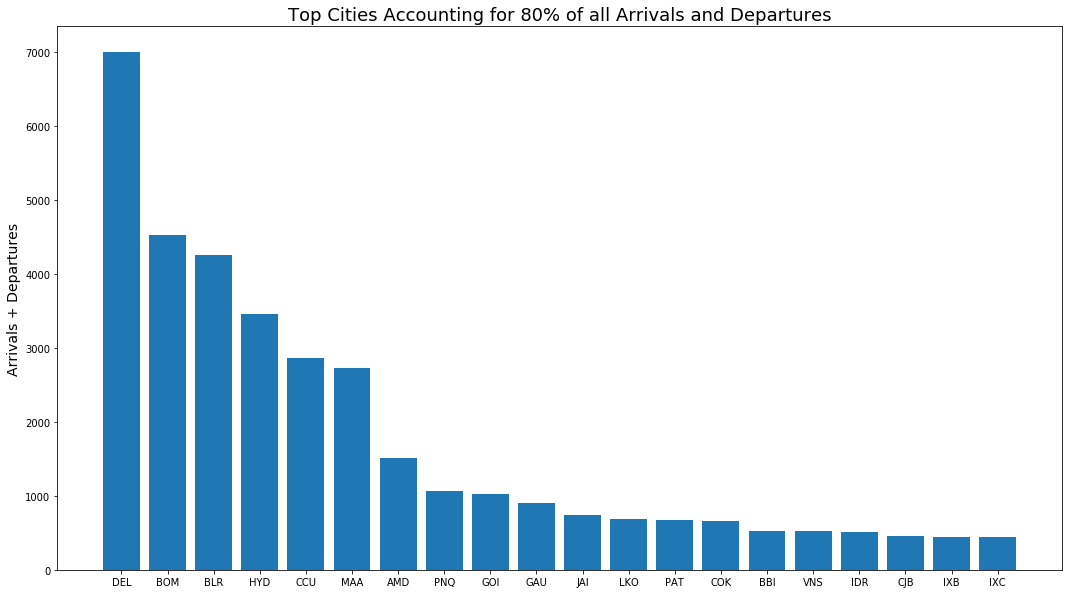

In [31]:
with open('./data/processed/codes_to_city_dict.txt', 'rb') as handle:
    codes_to_city = pickle.loads(handle.read())

sdat = sdat.sort_values(by = ['total_weekly_flights'], ascending = False)
total_ = sdat['total_weekly_flights'].sum()

sdat['%_total_weekly_flights'] = round(sdat['total_weekly_flights'].cumsum()/total_, 2)

top_cities_by_mvmnts = sdat.loc[sdat['%_total_weekly_flights'] <= 0.8, :].index.tolist()
top_cities_by_name = [codes_to_city[top_cities_by_mvmnts[i]] for i in range(len(top_cities_by_mvmnts))]

print('%i cities account for 80%% of all arrivals and departures.\n' % len(top_cities_by_mvmnts))
print('Cities accounting for 80% of all arrivals and departures:\n', top_cities_by_name)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_by_flts, sdat['total_weekly_flights'][0:len(top_cities_by_mvmnts)])
plt.title('Top Cities Accounting for 80% of all Arrivals and Departures', size = 18)
plt.ylabel('Arrivals + Departures', size = 14)
plt.show()

#### Top Cities by Weekly Total Capacity

17 cities account for 80% of total weekly capacity.

Cities accounting for 80% of total weekly capacity:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Indore', 'Varanasi']


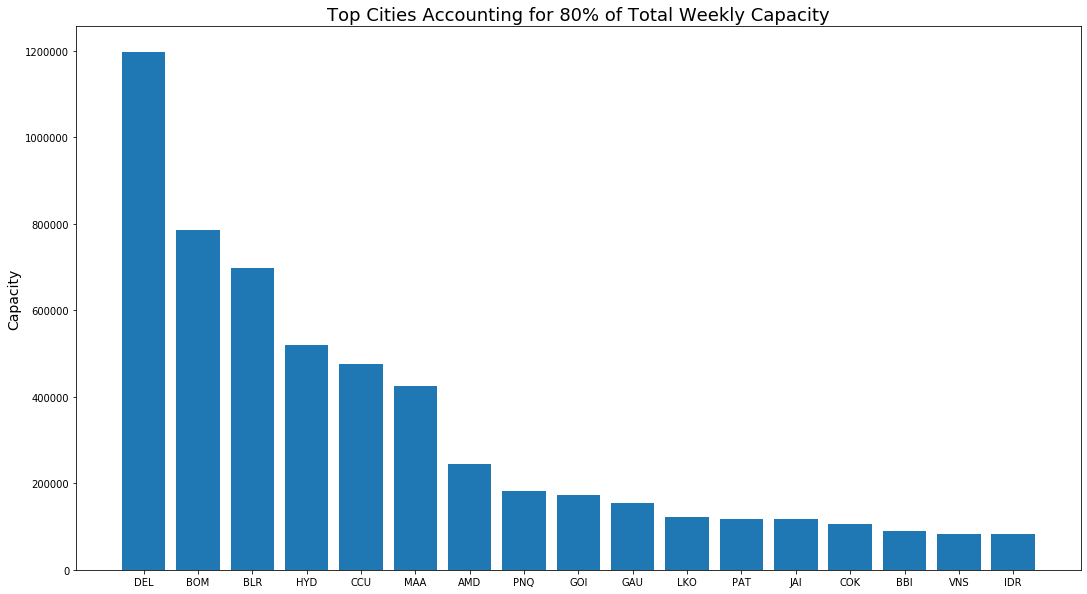

In [32]:
sdat = sdat.sort_values(by = ['total_weekly_capacity'], ascending = False)
total_ = sdat['total_weekly_capacity'].sum()

sdat['%_total_weekly_capacity'] = round(sdat['total_weekly_capacity'].cumsum()/total_, 2)

top_cities_by_cap = sdat.loc[sdat['%_total_weekly_capacity'] <= 0.8, :].index.tolist()
top_cities_by_name = [codes_to_city[top_cities_by_cap[i]] for i in range(len(top_cities_by_cap))]

print('%i cities account for 80%% of total weekly capacity.\n' % len(top_cities_by_cap))
print('Cities accounting for 80% of total weekly capacity:\n', top_cities_by_name)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, sdat['total_weekly_capacity'][0:len(top_cities_by_cap)])
plt.title('Top Cities Accounting for 80% of Total Weekly Capacity', size = 18)
plt.ylabel('Capacity', size = 14)
plt.show()

#### Top Cities by Weekly Total Estimated Passengers

17 cities account for 80% of total estimated weekly passengers.

Cities accounting for 80% of total estimated weekly passengers:
 ['New Delhi', 'Mumbai', 'Bangalore', 'Hyderabad', 'Kolkata', 'Chennai', 'Ahmedabad', 'Pune', 'Goa', 'Guwahati', 'Lucknow', 'Patna', 'Jaipur', 'Kochi', 'Bhubaneswar', 'Varanasi', 'Indore']


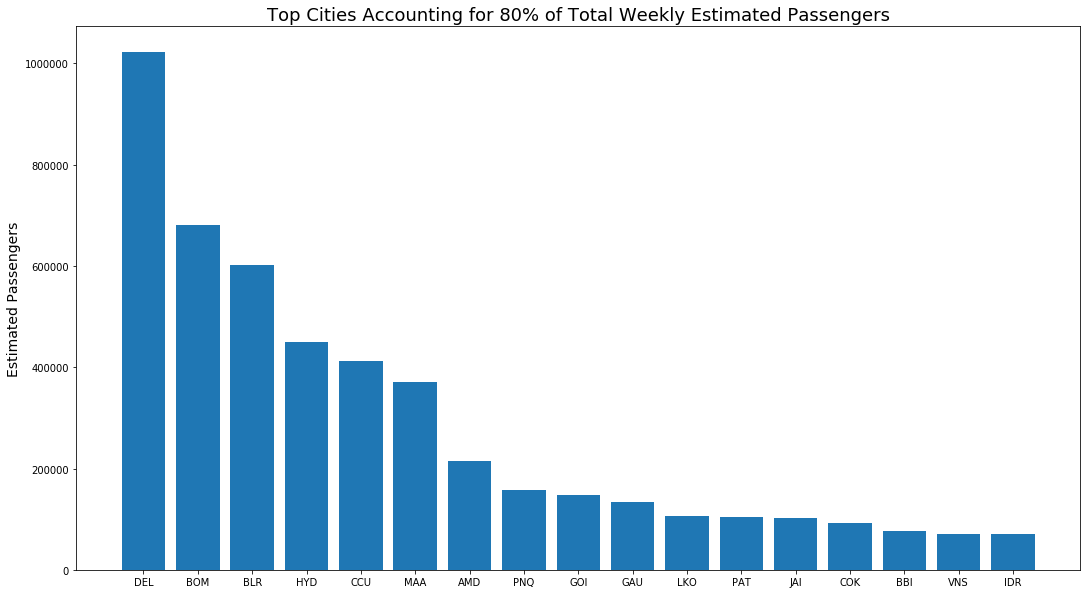

In [33]:
sdat = sdat.sort_values(by = ['total_weekly_est_pass'], ascending = False)
total_ = sdat['total_weekly_est_pass'].sum()

sdat['%_total_weekly_est_pass'] = round(sdat['total_weekly_est_pass'].cumsum()/total_, 2)

top_cities_by_pass = sdat.loc[sdat['%_total_weekly_est_pass'] <= 0.8, :].index.tolist()
top_cities_by_name = [codes_to_city[top_cities_by_pass[i]] for i in range(len(top_cities_by_pass))]

print('%i cities account for 80%% of total estimated weekly passengers.\n' % len(top_cities_by_pass))
print('Cities accounting for 80% of total estimated weekly passengers:\n', top_cities_by_name)

plt.figure(figsize = (18, 10))
plt.bar(top_cities_code, sdat['total_weekly_est_pass'][0:len(top_cities_by_pass)])
plt.title('Top Cities Accounting for 80% of Total Weekly Estimated Passengers', size = 18)
plt.ylabel('Estimated Passengers', size = 14)
plt.show()

### Day-of-Week

#### Distribution of Total Movements

<ul>
    <li>Plot the day-wise distribution for all arrivals and departures combined across all cities.
    <li>For the top cities by total weekly movements, for each city:
        <ol>
            <li>identify all schedules in and out of the city.
            <li>group the schedules by day of the week and count the total number of flights for the day.
            <li>plot the spread of the total daily movements for the city

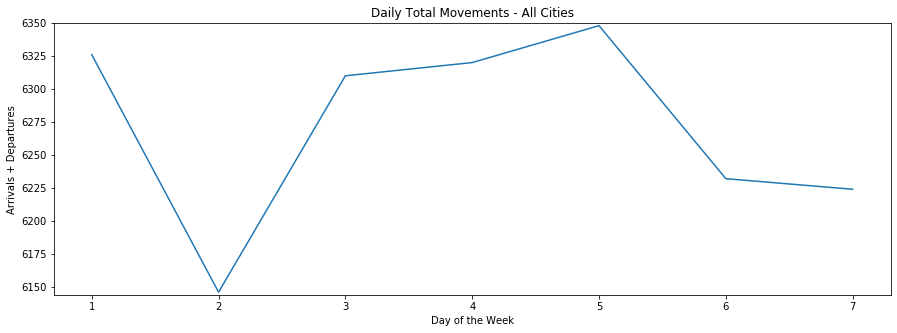

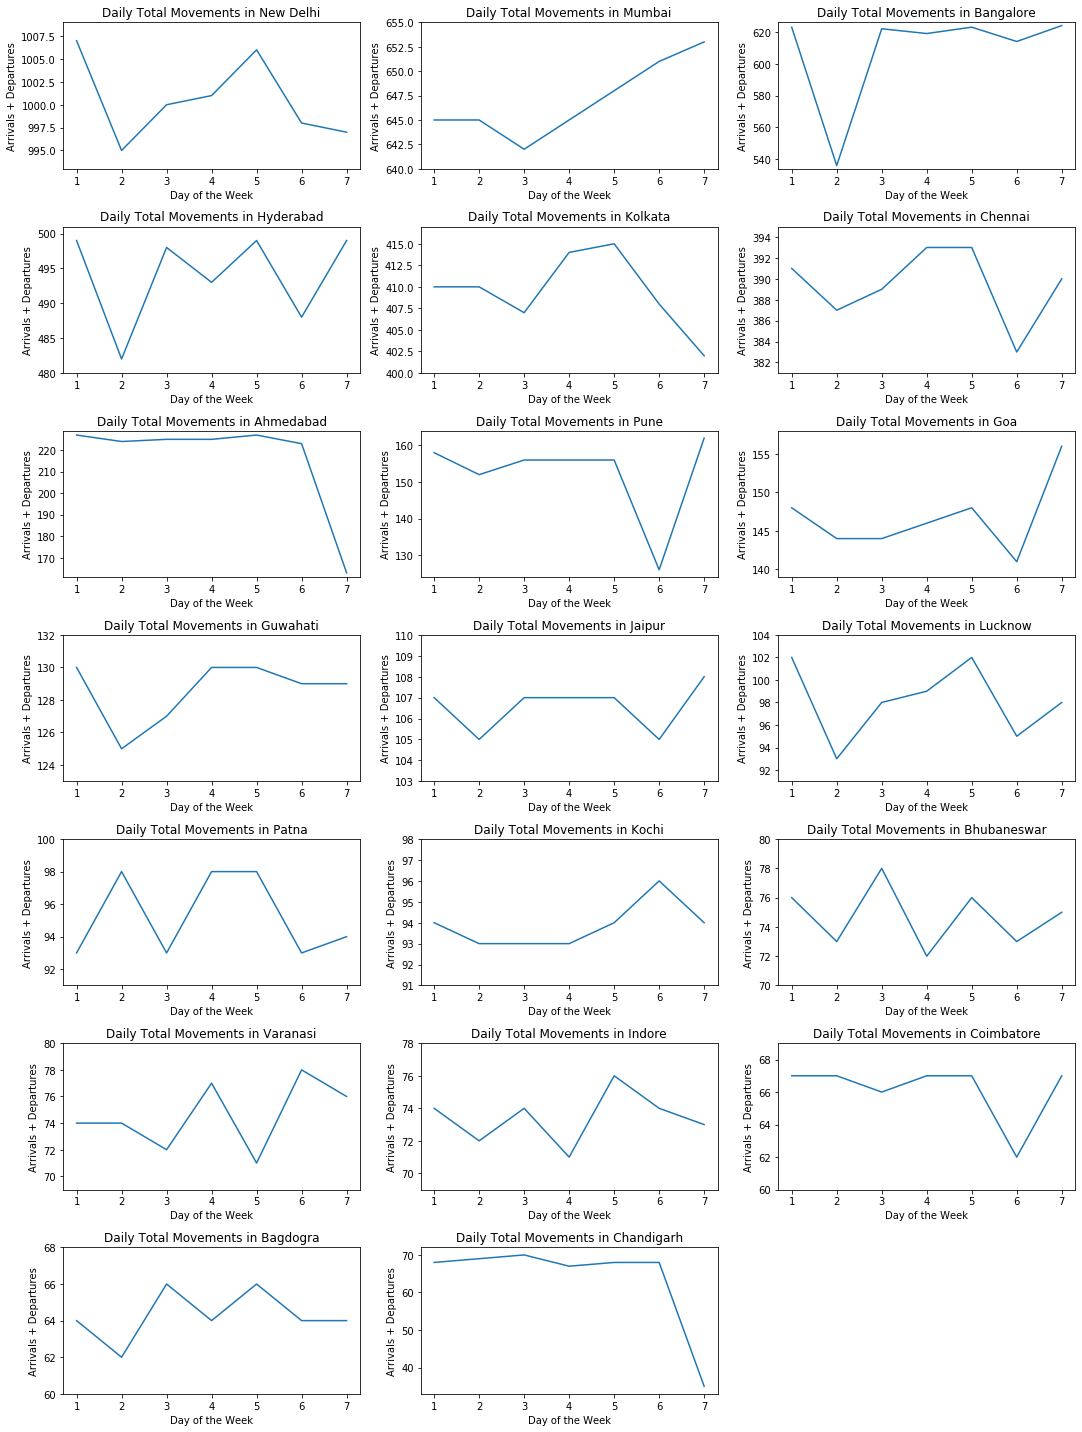

In [74]:
''' When combined across all cities, for any day, the total number of arrivals must be equal to the total 
number of departures. However, this may not be true when considering a particular city, i.e. the total number 
of arrivals in a city may not be the same as the total number of departures '''

plt.figure(figsize = (15, 5))

daily_mvmnts_from = []
daily_mvmnts = []
for i in range(1,8,1):
    day = 'day_' + str(i)
    daily_mvmnts_from.append(dat.groupby([day, 'from'])[day].count()[1].sum())
    
daily_mvmnts = [i*2 for i in daily_mvmnts_from]

plt.plot(np.arange(1,8,1), daily_mvmnts)
plt.ylim((min(daily_mvmnts) - 2, max(daily_mvmnts) + 2))
plt.xlabel('Day of the Week')
plt.ylabel('Arrivals + Departures')
plt.title('Daily Total Movements - All Cities')
plt.show()

plt.figure(figsize = (15, 20))
ncol = 3
nrow = np.ceil(len(top_cities_by_mvmnts)/3)
subplot_= 1
for city_code in top_cities_by_mvmnts:
    daily_mvmnts = []
    
    idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
    sdat = dat.iloc[idx, :]
        
    idx_in = [i for i in sdat.index if sdat['from'][i] != city_code] # flights into the city
    idx_out = [i for i in sdat.index if sdat['to'][i] != city_code]  # flights out of the city
    
    for i in range(1,8,1):
        day = 'day_' + str(i)
        daily_mvmnts_to = sdat.loc[idx_in, :].groupby([day, 'from'])[day].count()[1].sum()
        daily_mvmnts_from = sdat.loc[idx_out, :].groupby([day, 'to'])[day].count()[1].sum()
        daily_mvmnts.append(daily_mvmnts_to + daily_mvmnts_from)
    
    plt.subplot(nrow, ncol, subplot_)
    subplot_ = subplot_ + 1
    plt.plot(np.arange(1,8,1), daily_mvmnts)
    plt.ylim((min(daily_mvmnts) - 2, max(daily_mvmnts) + 2))
    plt.xlabel('Day of the Week')
    plt.ylabel('Arrivals + Departures')
    plt.title('Daily Total Movements in %s' % codes_to_city[city_code])

plt.tight_layout()
plt.show()

### Time-of-Day Distribution

In [185]:
def plot_hourly(timeslot_arr, timeslot_dep, city_name = 'All Cities'):
    
    plt.plot(np.arange(1,49,1), timeslot_arr, label = 'arrivals')
    plt.plot(np.arange(1,49,1), timeslot_dep, label = 'departures')
    #plt.ylim((min(timeslot_arr) - 5, max(timeslot_arr) + 5))
    plt.xlim((1, 48))
    plt.xticks(np.arange(0, 48, 2))
    plt.axvline(x = 12, color = 'grey', linestyle = '--')
    plt.axvline(x = 24, color = 'grey', linestyle = '--')
    plt.axvline(x = 36, color = 'grey', linestyle = '--')
    plt.xlabel('Time Slot of the Day')
    plt.ylabel('Arrivals + Departures')
    plt.title('Hourly Movements for the Week - %s' % city_name)
    plt.legend()

In [186]:
def fill_missing(series, slots, na_val):
    
    if series.shape[0] != slots:
        missing_idx = list(set(np.arange(1, slots+1, 1)).difference(series.index))
        for i in missing_idx:
            series[float(i)] = 0
    
    series = series.sort_index()
    return series

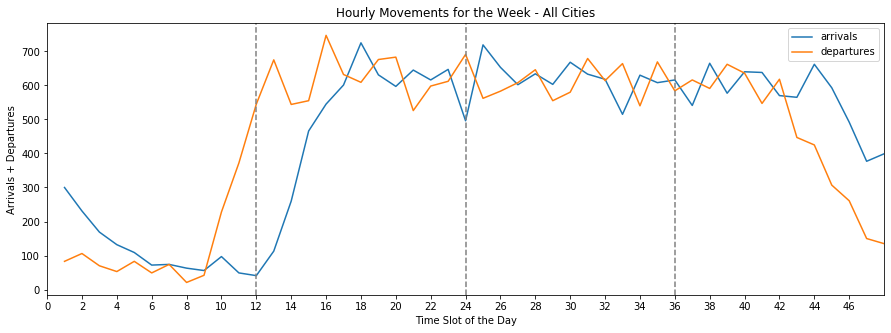

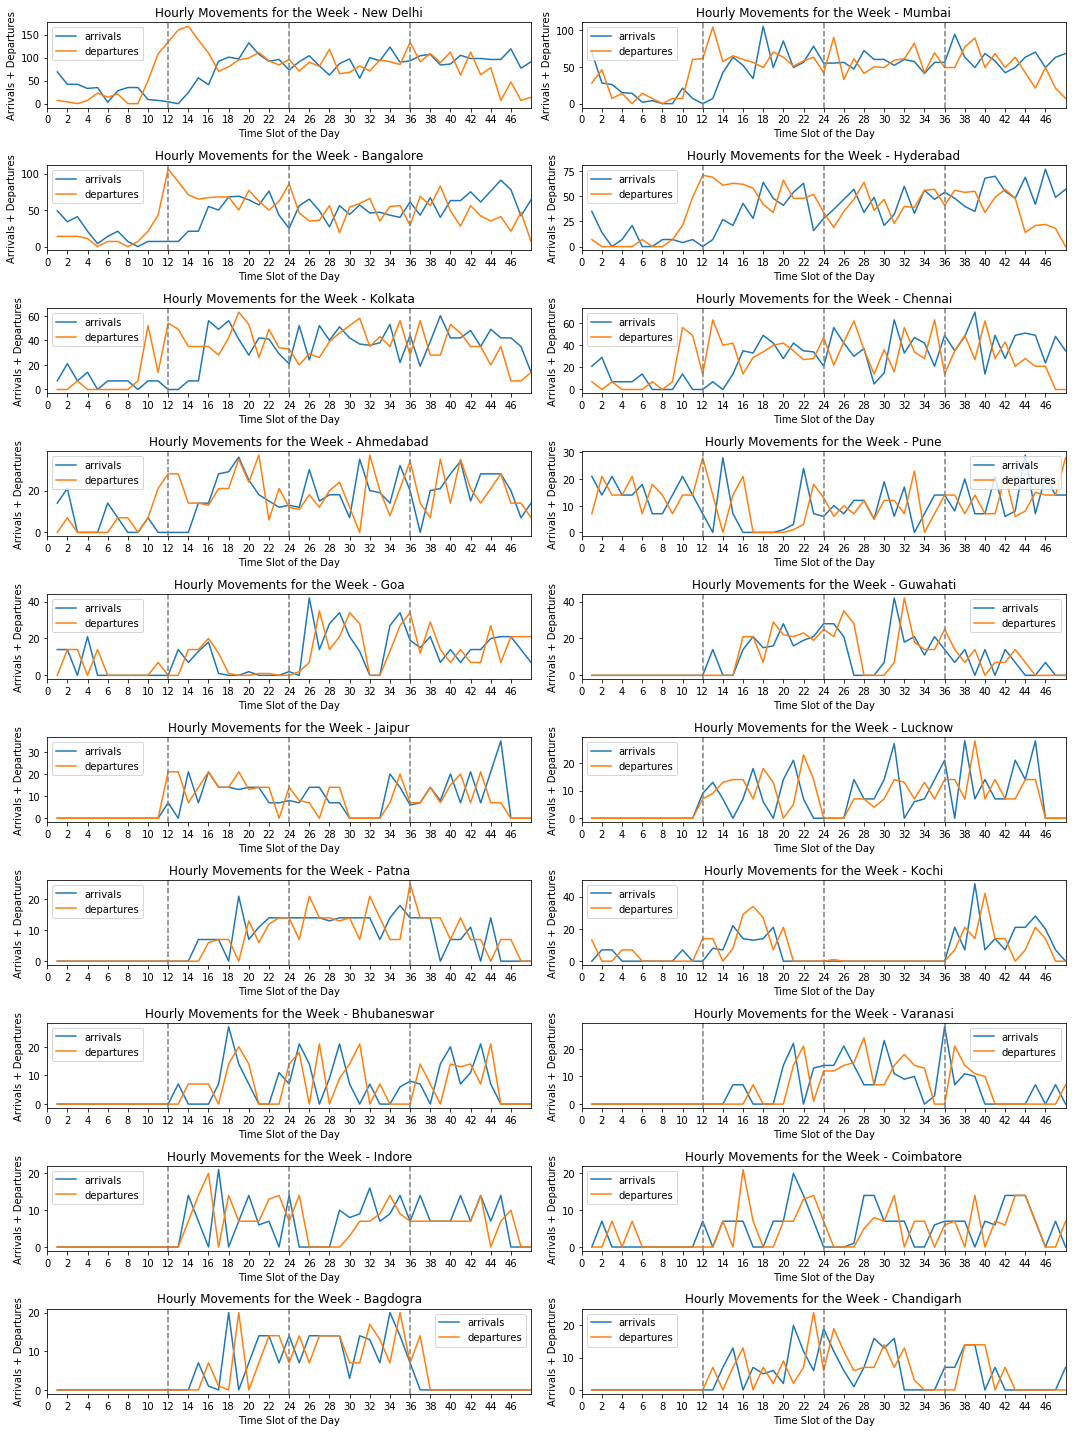

In [191]:
''' When combined across all cities, for any day, the total number of arrivals must be equal to the total 
number of departures. However, this may not be true when considering a particular city, i.e. the total number 
of arrivals in a city may not be the same as the total number of departures '''

plt.figure(figsize = (15, 5))

timeslot_arr = dat.groupby(['to_time_slot'])['weekly_flights'].sum()
timeslot_arr = fill_missing(timeslot_arr, 48, 0)
timeslot_dep = dat.groupby(['from_time_slot'])['weekly_flights'].sum()
timeslot_dep = fill_missing(timeslot_dep, 48, 0)

plot_hourly(timeslot_arr, timeslot_dep)
plt.show()

plt.figure(figsize = (15, 20))
ncol = 2
nrow = np.ceil(len(top_cities_by_mvmnts)/ncol)
subplot_= 1
for city_code in top_cities_by_mvmnts:
    timeslot_arr = []
    timeslot_dep = []
    
    idx = [i for i in dat.index if dat['from'][i] == city_code or dat['to'][i] == city_code]
    sdat = dat.iloc[idx, :]
        
    idx_in = [i for i in sdat.index if sdat['to'][i] == city_code] # flights into the city
    idx_out = [i for i in sdat.index if sdat['from'][i] == city_code]  # flights out of the city
    
    timeslot_arr = sdat.loc[idx_in, :].groupby(['to_time_slot'])['weekly_flights'].sum()
    timeslot_arr = fill_missing(timeslot_arr, 48, 0)
    timeslot_dep = sdat.loc[idx_out, :].groupby(['from_time_slot'])['weekly_flights'].sum()
    timeslot_dep = fill_missing(timeslot_dep, 48, 0)
    
    plt.subplot(nrow, ncol, subplot_)
    plot_hourly(timeslot_arr, timeslot_dep, codes_to_city[city_code])
    subplot_ += 1

plt.tight_layout()
plt.show()